# Demo: EOF decomposition of monthly SST data using `xeofs` package

This demo replicates part of an EOF analysis on sea surface temperatures published in Journal of Climate (Messie and Chavez, 2011): https://doi.org/10.1175/2011JCLI3941.1. 

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.


Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

Github issue with valuable information on scaling the output from the xeofs package in different ways (for example the initial xeofs output does not match the scale of the publication): https://github.com/nicrie/xeofs/issues/81 

In [1]:
## Need latest versions (as of October 2023) of all the below packages to ensure this notebook works

import earthaccess

import xarray as xr
import numpy as np
import xeofs as xe
from eofs.standard import Eof

import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree

import coiled

%matplotlib inline

# 1. Locate SST data file endpoints and load data with `Xarray`

## 1.1 Locate endpoints
The `earthaccess` package is used to login to Earthdata and locate endpoints for all needed data files. The endpoints will be used with `Xarray` to access the data without downloading.

In [2]:
earthaccess.login() # Login with your credentials

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using user provided credentials for EDL


In [3]:
%%time

# Locate endpoints on Earthdata Cloud:
endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2008-02-01"), # We only want till end of 2007, but this ending date was required to obtain that.
    )

Granules found: 1178
CPU times: user 237 ms, sys: 16.2 ms, total: 253 ms
Wall time: 33.9 s


In [4]:
# Generate file objects from the endpoints which are compatible with Xarray:
fileobjs = earthaccess.open(endpoints[1:]) # The month prior to 1910-01-01 is included in the returned endpoints (bug?), so start the list at the 2nd element.

 Opening 1177 granules, approx size: 0.12 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

**Removal of one of the file objects which returned a bad result**

These lines of code are not typically needed for other datasets, but for some reason earthaccess returns one endpoint for a file which does not exist. Remove this element from the file objects list:

In [5]:
# Print the bad result just for reference:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

# Remove this bad result from the list:
fileobjs = [f for f in fileobjs if type(f) != FileNotFoundError]

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


## 1.2 Load data

If working in the cloud, loading and combining all files for this analysis into a single dataset object will take 2-4 minutes. This can be sped up using e.g. `kerchunk` or parallelization with remote clusters, but to simplify this notebook those methods are not implemented.

Since we are using Xarray's `open_mfdataset()` the returned object includes Dask arrays instead of NumPy arrays. The SST data is small enough that we can load it all into memory, which we will do so that we can procede even if you are not familiar with Dask arrays (all you need to know is that we have not actually loaded the data into memory yet, so we need one more step after loading the data). 

In [7]:
%%time

# Load data:
sstdata = xr.open_mfdataset(fileobjs)
sstdata = sstdata.squeeze() # Remove the unnecessary 'lev' dimension (size 1)
sstdata

CPU times: user 37.4 s, sys: 501 ms, total: 37.9 s
Wall time: 3min 34s


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [11]:
# Load the SST data into DataArry object containing NumPy a array:
sst = sstdata['sst'].load()
sst

<xarray.DataArray 'sst' (time: 1176, lat: 89, lon: 180)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:      -3.0
    valid_max:      45.0

# 2. Preprocessing, Linear Detrend, and Remove Seasonal Cycle

As in the publication, we remove the long term linear trend and the seasonal cycle from the SST timeseries at each gridpoint, since we are interested in other modes of variablility. This is done using Xarray built in functions but can also be achieved with NumPy functions. 

## 2.1 Proprocessing

In [18]:
# Before proceeding, remove data poleward of 65 degress lat (as in the publication):
sst = sst.sel(lat=slice(-65, 65))

### 2.1 Linear Detrend

**Compute and remove linear trend**

In [20]:
p = sst.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst - fit) # xarray is smart enough to subtract along the time dim only.

**Test plot of detrend results at a few locations on the globe**

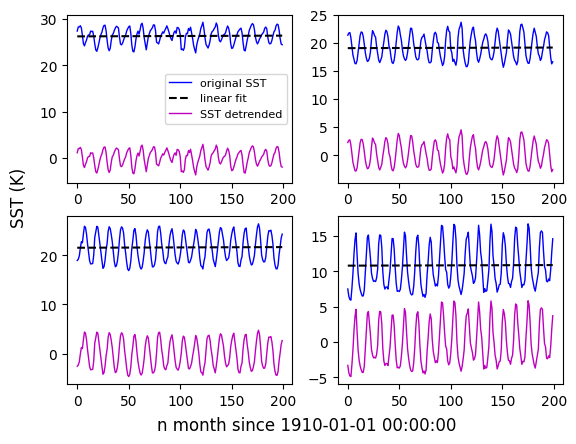

In [51]:
# Find lats, lons in the dataset that are closest to a few chosen values.
testpoints = sst.sel(lat=[0, -30, 30, 45], lon=[0, 90, 190, 220], method='nearest')
lat_testpoints = testpoints['lat'].data
lon_testpoints = testpoints['lon'].data


# Plot before, after, and detrend fit for first 200 timestamps:
n_ts = 200

fig1, axes1 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes1.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'b-', linewidth=1, label='original SST')
    ax.plot(fit.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k--', label='linear fit')
    ax.plot(sst_detrend.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')

fig1.text(0.5, 0.025, "n month since " + str(sst['time'].data[0]), ha='center', va='center', fontsize=12)
fig1.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)
axes1[0,0].legend(fontsize=8)

### 2.2 Remove Seasonal Cycle

**Computation**

In [52]:
# Very easy to remove a daily/monthly/yearly/etc cycle using Xarray built-in function:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")
sst_nocycle = sst_detrend.groupby("time.month") - seasonal_cycle

**Create some confirmation plots at same test points as in Section 2.1**

Text(0.05, 0.5, 'SST (K)')

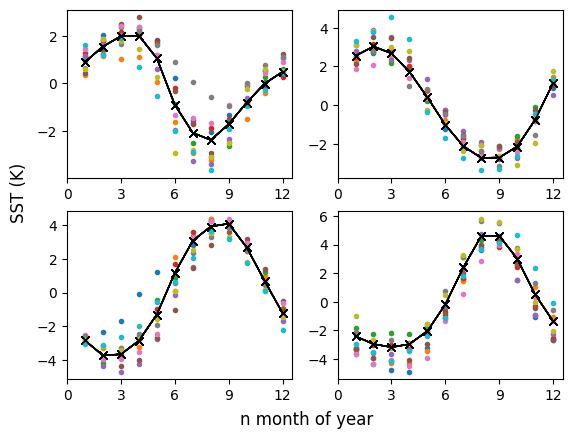

In [64]:
# Mean seasonal cycle overlaid on data for first 10 years:
fig2, axes2 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes2.flatten(), lat_testpoints, lon_testpoints):
    for i in np.arange(1,11):
        ax.plot(seasonal_cycle['month'], sst_detrend.isel(time=range(12*(i-1), 12*i)).sel(lat=lat, lon=lon), '.')
        ax.plot(seasonal_cycle['month'], seasonal_cycle.sel(lat=lat, lon=lon), 'kx-', linewidth=1)

xticks = [0, 3, 6, 9, 12]
for ax in axes2.flatten():
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xt) for xt in xticks])
fig2.text(0.5, 0.025, "n month of year", ha='center', va='center', fontsize=12)
fig2.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)

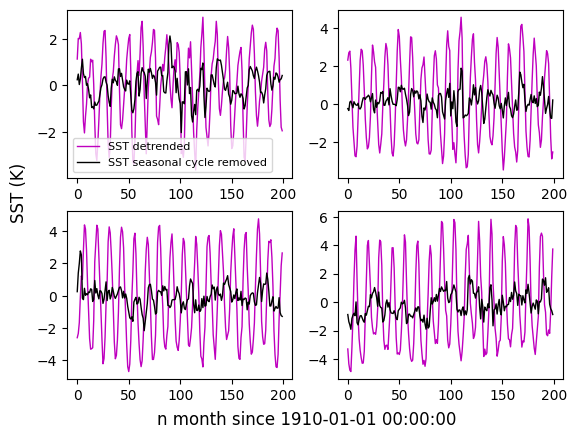

In [65]:
# Plot before and after cycle removal, for first 200 timestamps:
fig3, axes3 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes3.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst_detrend.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')
    ax.plot(sst_nocycle.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k-', linewidth=1, label='SST seasonal cycle removed')

fig3.text(0.5, 0.025, "n month since " + str(sst['time'].data[0]), ha='center', va='center', fontsize=12)
fig3.text(0.05, 0.5, "SST (K)", ha='center', va='center', fontsize=12, rotation=90)
axes3[0,0].legend(fontsize=8)

## Variance map

A vmax of 1 is used because there are a few points over the globe with anomolously high variances.

In [75]:
sstvar = sst_nocycle.var(dim=['time'], skipna=True)

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/nputils.py:183: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


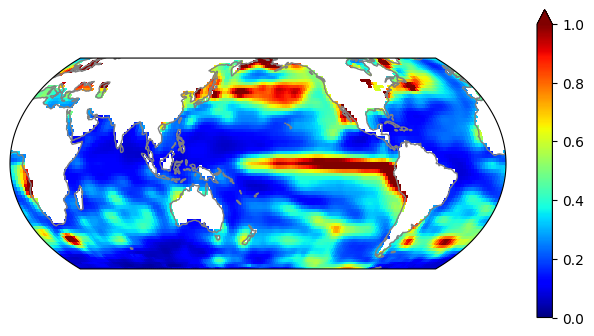

In [76]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
sstvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

In [77]:
sst_nocycle = sst_nocycle.where(sstvar < 2, drop=False) # Remove a few points with anomolously high variances.

## 3. EOF decomp

**Fit the model**

In [78]:
wgts = np.cos(np.deg2rad(sst_nocycle['lat']))**0.5 # Common practice to weight by latitude

In [79]:
%%time

model = xe.models.EOF(
    n_modes=6,
    use_weights=True,
    standardize=False
    )
model.fit(sst_nocycle, dim='time', weights=wgts)

CPU times: user 505 ms, sys: 108 ms, total: 613 ms
Wall time: 612 ms


**Compute PCAs (scores), EOFs (components), and explained variances**

In [80]:
%%time

expvar = model.explained_variance_ratio()
expvar.values

CPU times: user 521 µs, sys: 14 µs, total: 535 µs
Wall time: 540 µs


array([0.15566093, 0.04830667, 0.03850467, 0.03468491, 0.03283798,
       0.0275927 ])

In [81]:
%%time

# The package automatically normalizes the returned PCA's ("scores"). We back out the raw scores here:
scores = model.scores()
svals = model.singular_values()
scores_raw = scores * svals

CPU times: user 1.95 ms, sys: 55 µs, total: 2 ms
Wall time: 1.86 ms


In [82]:
%%time

# EOFs ("components"):
components = model.components()

CPU times: user 2.16 ms, sys: 0 ns, total: 2.16 ms
Wall time: 1.77 ms


**Plot EOFs and PCA's**

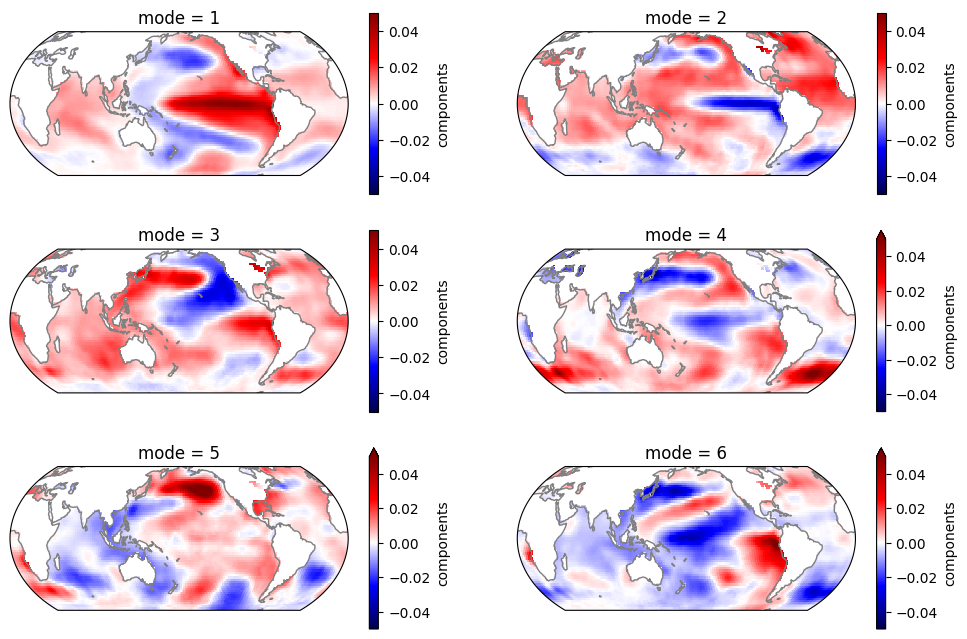

In [83]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    'cmap' : 'seismic', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, vmin=-0.05, vmax=0.05, **kwargs)
    #components.sel(mode=i).plot(ax=ax, vmin=-2, vmax=2, **kwargs)
    #components.sel(mode=i).plot(ax=ax, **kwargs)

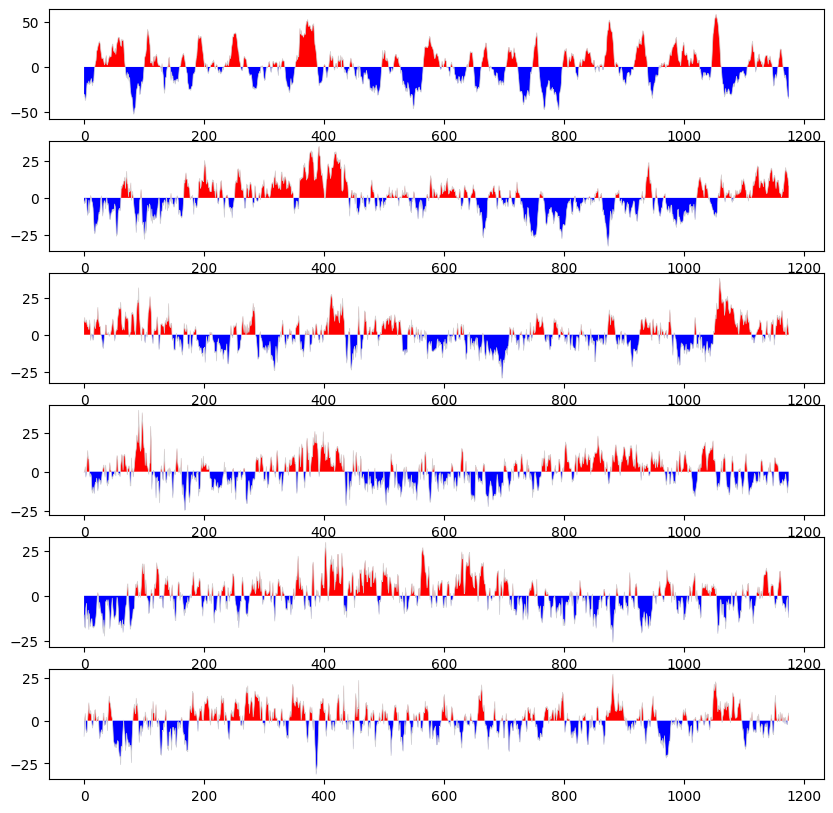

In [84]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

x = range(len(scores['time']))
zeroline = np.zeros(len(x))

for i, ax in zip(range(1, 7), axes5):
    scores_raw_i = scores_raw.sel(mode=i).values
    pos_score = scores_raw_i > 0
    ax.fill_between(x, scores_raw_i, zeroline, where=pos_score, facecolor='red', interpolate=True)
    ax.fill_between(x, scores_raw_i, zeroline, where=~pos_score, facecolor='blue', interpolate=True)
    ax.plot(scores_raw_i, color='lightgrey', linewidth=0.5)
    #ax.set_ylim(-1, 1)

In [ ]:
# Due to the way in which the ERSST data files were originally created, 
timestamps_np = [np.datetime64(str(t)) for t in sst['time'].data]